# Load raw files and importing

In [1]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

fraud_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/Fraud_Data.csv', parse_dates=["signup_time", "purchase_time"])
ip_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/IpAddress_to_Country.csv')
credit_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/creditcard.csv')

# Initial Summary
Checks conducted for duplicates, missing and null values. Overviews of shape and datatypes

In [2]:
def initial_summary(df, name):
    print(f"\n=== {name} ===")
    
    # Shape
    print("Shape:", df.shape)
    
    # Data types
    print("\nData types:")
    print(df.dtypes)

    # Check if any nulls exist (overall)
    has_nulls = df.isnull().values.any()
    print(f"\nAny null values present? {has_nulls}")
    
    # If there are nulls, list columns + counts
    if has_nulls:
        null_counts = df.isnull().sum()
        print("Nulls per column:")
        print(null_counts[null_counts > 0])
    
    # Missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # Duplicate rows
    print("\nTotal duplicate rows:", df.duplicated().sum())
    
    # Preview
    print("\nFirst 5 rows:")
    display(df.head())
    
# 3. Run summary on each raw dataset
initial_summary(fraud_raw,  "Fraud Data")
initial_summary(credit_raw, "Credit-Card Data")
initial_summary(ip_raw,     "IP→Country Mapping")


=== Fraud Data ===
Shape: (151112, 11)

Data types:
user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

Any null values present? False

Missing values per column:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Total duplicate rows: 0

First 5 rows:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0



=== Credit-Card Data ===
Shape: (284807, 31)

Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Any null values present? False

Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25      

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



=== IP→Country Mapping ===
Shape: (138846, 3)

Data types:
lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

Any null values present? False

Missing values per column:
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

Total duplicate rows: 0

First 5 rows:


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


Initial audit shows that credit card data has 1081 duplicate rows. Next step is to drop duplicates and align schema with the fraud table.
In the credit dataset, there is no user_id, so any repeat in Time,V1...V28, Amount, Class is almost certainly a data‐entry or merge artifact not a repeat transaction

# Handling Duplicate CC Transactions

In [3]:
# Remove duplicates in credit_raw
print("Duplicates before:", credit_raw.duplicated().sum())

credit_raw = (
    credit_raw
    .drop_duplicates()
    .reset_index(drop=True)
)

print("Shape after deduplication:", credit_raw.shape)
print("Duplicates after :", credit_raw.duplicated().sum())

Duplicates before: 1081
Shape after deduplication: (283726, 31)
Duplicates after : 0


In [4]:
# Rename Class → class to streamline later merges and analyses in line with fraud dataset
credit_raw.rename(columns={'Class':'class'}, inplace=True)

print("Columns now:", credit_raw.columns.tolist())

Columns now: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'class']


In [5]:
# Quick sanity check
print("Any nulls?            ", credit_raw.isnull().any().any())
print("Total duplicates now:", credit_raw.duplicated().sum())

Any nulls?             False
Total duplicates now: 0


# Check Class Imbalance in Raw Fraud and CC Data

Fraud Data — Class Distribution (%):
class
0    90.64
1     9.36
Name: proportion, dtype: float64



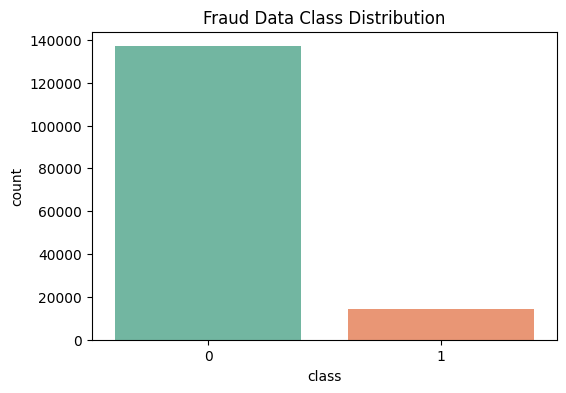

Credit-Card Data — Class Distribution (%):
class
0    99.83
1     0.17
Name: proportion, dtype: float64



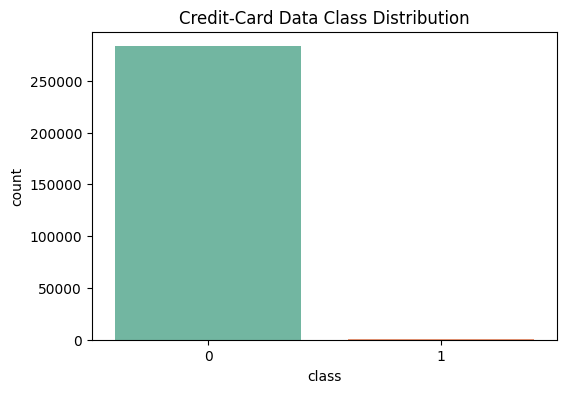

In [6]:
# Class imbalance for both datasets

def plot_class_balance(df, title, palette="Set2"):
    # Compute and print percentages
    pct = df['class'].value_counts(normalize=True).mul(100).round(2)
    print(f"{title} — Class Distribution (%):\n{pct}\n")
    
    plt.figure(figsize=(6,4))
    sns.countplot(x='class',
                  hue='class',
                  data=df,
                  palette=palette,
                  legend=False)
    plt.title(f"{title} Class Distribution")
    plt.xlabel("class")
    plt.ylabel("count")
    plt.show()

for df, name in [(fraud_raw, "Fraud Data"), (credit_raw, "Credit-Card Data")]:
    plot_class_balance(df, name)

- The fraud dataset has moderate imbalance — standard metrics like F1 or AUC can still be meaningful, and class weights might be enough to compensate.
- The credit-card dataset is severely skewed — this can mislead any model that predicts "legit" every time with 99% accuracy. 

# Merge dataset and check overall skew

In [7]:
# 1. Rename target columns if needed
fraud_raw.rename(columns={'Class':'class'}, inplace=True)
credit_raw.rename(columns={'Class':'class'}, inplace=True)

# 2. Merge
full_df = pd.concat([fraud_raw, credit_raw], ignore_index=True)

# 3. Inspect combined skew
overall_pct = (
    full_df['class']
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
)
print("Combined Data — Class Distribution (%):")
print(overall_pct)

Combined Data — Class Distribution (%):
class
0    96.64
1     3.36
Name: proportion, dtype: float64
